# **Using Tensorflow for detecting Covid-19 Infected Lungs from Normal Lungs with Chest X-Ray**

Training the model on the train dataset.

# RESNET MODEL



In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive

In [ ]:
IMAGE_SIZE = (256, 256)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

Importing the libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_height, img_width= IMAGE_SIZE
batch_size=16
train_datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.2,shear_range=0.2,validation_split=0.3)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')
validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

Found 5064 images belonging to 2 classes.
Found 2168 images belonging to 2 classes.


Resnet model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Model

In [ ]:
resnet50 = ResNet50(include_top=False,input_shape=(256,256,3))

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
for layer in resnet50.layers:
  layer.trainable=False

In [ ]:
x = Flatten()(resnet50.output)

In [ ]:
output = Dense(1,activation='sigmoid')(x)

In [ ]:
resnet50 = Model(resnet50.input,output)

In [ ]:
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
resnet50.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
resnet50.fit(train_generator,validation_data=validation_generator,epochs=5)

Epoch 1/5
317/317 [==============================] - 5727s 18s/step - loss: 0.8494 - accuracy: 0.6487 - val_loss: 0.4821 - val_accuracy: 0.7947
Epoch 2/5
317/317 [==============================] - 151s 476ms/step - loss: 0.6039 - accuracy: 0.7291 - val_loss: 0.4372 - val_accuracy: 0.8178
Epoch 3/5
317/317 [==============================] - 150s 475ms/step - loss: 0.7934 - accuracy: 0.7038 - val_loss: 0.9830 - val_accuracy: 0.5729
Epoch 4/5
317/317 [==============================] - 149s 471ms/step - loss: 0.7350 - accuracy: 0.7239 - val_loss: 0.6063 - val_accuracy: 0.7477
Epoch 5/5
317/317 [==============================] - 149s 470ms/step - loss: 0.6616 - accuracy: 0.7330 - val_loss: 0.4179 - val_accuracy: 0.8335


In [ ]:
# Get predictions
probabilities = resnet50.predict(validation_generator)

# Display the probabilities
print(probabilities)

136/136 [==============================] - 47s 338ms/step
[[0.98973256]
 [0.6434379 ]
 [0.99989045]
 ...
 [0.9979254 ]
 [0.08579028]
 [0.9466488 ]]


In [ ]:
y_true = validation_generator.classes
y_true

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
y_pred = probabilities > 0.5
y_pred

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [False],
       [ True]])

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

[[583 501]
 [587 497]]


<Axes: >

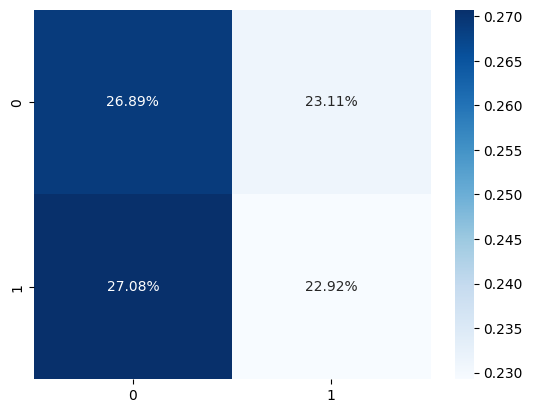

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.2%', cmap='Blues')

In [ ]:
import numpy as np

def calculate_metrics(confusion_matrix):
    # Extract values from the confusion matrix
    TP = confusion_matrix[1, 1]
    TN = confusion_matrix[0, 0]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]

    # Calculate accuracy
    accuracy = (TP + TN) / np.sum(confusion_matrix)

    # Calculate precision
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0

    # Calculate recall (sensitivity/TPR)
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0

    # Calculate specificity
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    return accuracy, precision, recall, specificity

accuracy, precision, recall, specificity = calculate_metrics(cf_matrix)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {specificity:.2f}')


Accuracy: 0.50
Precision: 0.50
Recall: 0.46
Specificity: 0.54


In [ ]:
resnet50.save("resnet50.keras")